In [1]:
# import the ifcb module and other required modules
import glob
import ifcb
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

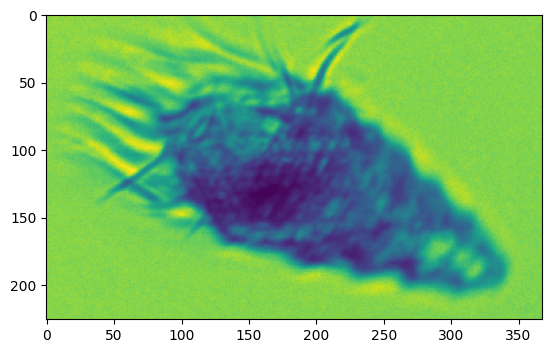

In [3]:
data_dir = ifcb.DataDirectory(os.path.join(os.path.expanduser('~'), 'ooi/cruise_data/pioneer-mab/Pioneer-20_AR82_2024-04-01/IFCB/discrete/'))
sample_bin = data_dir['D20240415T215238_IFCB206']
im = sample_bin.roi_file.get_image(562)
plt.imshow(im)

In [17]:
# raw data directory with the ADC files currently being telemetered to shore during the deployment
data_dir = os.path.join(os.path.expanduser('~'), 'ooi/uncabled/CP10CNSM/D00001/cg_data/dcl27/plims/D20240[456789]*.adc')
files = sorted(glob.glob(data_dir))  # listing of all the ADC files
print("Found {} files".format(len(files)))
# note, the file glob used above is constructed to deliberately exclude burn-in (aka parking lot) data

Found 812 files


In [5]:
%%time
# pull out the adc data from each adc file into a pandas dataframe and add the sampling date/time extracted from the file name
columns = 'TRIGGER ADC_TIME PMT_A PMT_B PMT_C PMT_D PEAK_A PEAK_B PEAK_C PEAK_D TIME_OF_FLIGHT GRAB_TIME_START GRAB_TIME_END ROI_X ROI_Y ROI_WIDTH ROI_HEIGHT START_BYTE COMPARATOR_OUT START_POINT SIGNAL_LENGTH STATUS RUN_TIME INHIBIT_TIME'.lower().split(' ')
columns = {index: value for index, value in enumerate(columns)}

full = []     # temporary list to hold the dataframes from each sampling run
summary = []  # summary results from each sampling run we can later merge with 
for file in files:
    # load the adc data and use the sample id to set the sampling time
    adc = ifcb.data.adc.AdcFile(file)
    sample_id = adc.lid
    sample_time = pd.Timestamp(sample_id[1:-8], tz='UTC')
    
    # convert the data to a pandas dataframe, rename the columns and drop any size 0 triggers
    adc = adc.to_dataframe()
    adc.rename(columns=columns, inplace=True)
    adc = adc[adc['roi_width'] > 0]
    
    # add the sample id and time that we can use later in grouping the data
    adc.insert(1, 'sample_id', sample_id)
    adc.insert(3, 'sample_time', sample_time)
    
    # append the results to the full and summary lists
    full.append(adc)
    area = (adc['roi_width'] / 2.7) * (adc['roi_height'] / 2.7)  # rough estimate of target area in um^2 (~2.7 pixels/um)
    summary.append([sample_time, sample_id, len(adc), np.mean(area)])

CPU times: user 3.95 s, sys: 528 ms, total: 4.48 s
Wall time: 31 s


In [6]:
%%time
# convert the full and summary lists into pandas dataframes
full = pd.concat(full, ignore_index=True)
full.index.rename('samples', inplace=True)

summary = np.array(summary)
summary = pd.DataFrame(summary[:, 1:], index=summary[:, 0], columns=['sample_id', 'target_counts', 'target_area'])
summary.index.rename('time', inplace=True)

CPU times: user 151 ms, sys: 101 ms, total: 252 ms
Wall time: 251 ms


In [7]:
%%time
grps = full.groupby('sample_id')
for grp in grps:
    pass

CPU times: user 177 ms, sys: 68.6 ms, total: 245 ms
Wall time: 244 ms


In [8]:
grp[1]

,trigger,sample_id,adc_time,sample_time,pmt_a,pmt_b,pmt_c,pmt_d,peak_a,peak_b,...,roi_y,roi_width,roi_height,start_byte,comparator_out,start_point,signal_length,status,run_time,inhibit_time
samples,,,,,,,,,,,,,,,,,,,,,
1375669,1,D20240922T042446_IFCB199,12.141865,2024-09-22 04:24:46+00:00,-0.000998,0.011843,-0.001829,-0.001004,0.009820,0.281713,...,803,80,58,0,0,0,0,0,12.164696,0.092693
1375670,2,D20240922T042446_IFCB199,13.948682,2024-09-22 04:24:46+00:00,0.084343,0.021247,-0.002023,-0.001178,1.365922,0.261614,...,387,88,50,4640,0,0,0,0,13.970365,0.176736
1375671,3,D20240922T042446_IFCB199,15.010232,2024-09-22 04:24:46+00:00,-0.000901,0.018660,-0.001870,-0.001065,0.009816,0.359943,...,523,72,42,9040,0,0,0,0,15.031645,0.259551
1375672,4,D20240922T042446_IFCB199,19.877021,2024-09-22 04:24:46+00:00,0.008152,0.012415,-0.001879,-0.001107,0.223012,0.204825,...,699,88,50,12064,0,0,0,0,19.899149,0.343255
1375673,5,D20240922T042446_IFCB199,26.224402,2024-09-22 04:24:46+00:00,-0.000285,0.002202,-0.001668,-0.000867,0.009592,0.005474,...,259,80,50,16464,0,0,0,0,26.246721,0.427322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375948,282,D20240922T042446_IFCB199,1187.321535,2024-09-22 04:24:46+00:00,-0.001272,0.000752,-0.002159,-0.001251,0.010190,0.005872,...,355,88,50,1638416,0,0,0,0,1187.358889,23.496810
1375949,283,D20240922T042446_IFCB199,1192.985101,2024-09-22 04:24:46+00:00,-0.001350,0.001310,-0.002194,-0.001268,0.010202,0.005875,...,499,64,34,1642816,0,0,0,0,1193.023194,23.580035
1375950,284,D20240922T042446_IFCB199,1196.085505,2024-09-22 04:24:46+00:00,0.005088,0.012646,-0.002367,-0.001363,0.158858,0.244203,...,627,96,66,1644992,0,0,0,0,1196.123333,23.662674


In [9]:
summary

,sample_id,target_counts,target_area
time,,,
2024-04-03 14:16:09+00:00,D20240403T141609_IFCB199,3666,752.229549
2024-04-03 15:26:20+00:00,D20240403T152620_IFCB199,4443,650.288381
2024-04-03 18:25:14+00:00,D20240403T182514_IFCB199,4073,621.513348
2024-04-03 21:25:11+00:00,D20240403T212511_IFCB199,6864,575.412882
2024-04-04 00:25:11+00:00,D20240404T002511_IFCB199,7272,570.638079
...,...,...,...
2024-09-21 12:24:45+00:00,D20240921T122445_IFCB199,1056,703.02095
2024-09-21 16:24:45+00:00,D20240921T162445_IFCB199,1661,640.211286
2024-09-21 20:24:44+00:00,D20240921T202444_IFCB199,259,756.532194


In [10]:
# import a utility used to load data from the kdata directory
from ooi_data_explorations.common import load_kdata

# import utilites used to re-organize and prepare the CTDBP and FLORT data for further work
from ooi_data_explorations.uncabled.process_ctdbp import ctdbp_datalogger
from ooi_data_explorations.uncabled.process_flort import flort_datalogger

In [11]:
%%time
ctd = load_kdata('CP10CNSM', 'RID27', '03-CTDBPC000', 'telemetered', 'ctdbp_cdef_dcl_instrument', '*.nc')
ctd = ctdbp_datalogger(ctd)

Loading and Processing Data Files: 100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Merging the data files into a single dataset
CPU times: user 185 ms, sys: 159 ms, total: 344 ms
Wall time: 4.47 s


In [12]:
%%time
flr = load_kdata('CP10CNSM', 'RID27', '02-FLORTD000', 'telemetered', 'flort_sample', '*FLORT*.nc')
flr = flort_datalogger(flr, burst=True)
# using burst-averaging here with the ECO Triplet data (sampled at 1 Hz for 3 minutes every 15 minutes) to reduce data volume

Loading and Processing Data Files: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]
Merging the data files into a single dataset
CPU times: user 2h 31min 53s, sys: 4.12 s, total: 2h 31min 57s
Wall time: 2min 45s


In [13]:
%%time
# create a merged data set, copying the source CTD data
merge = ctd.copy()

# interpolate the chlorophyll, FDOM and optical backscatter into the CTD record and add metadata
merge['estimated_chlorophyll'] = ('time', np.interp(ctd['time'], flr['time'], flr.estimated_chlorophyll))
merge['estimated_chlorophyll'].attrs = flr.estimated_chlorophyll.attrs
merge['fluorometric_cdom'] = ('time', np.interp(ctd['time'], flr['time'], flr.fluorometric_cdom))
merge['fluorometric_cdom'].attrs = flr.fluorometric_cdom.attrs
merge['optical_backscatter'] = ('time', np.interp(ctd['time'], flr['time'], flr.bback))
merge['optical_backscatter'].attrs = flr.bback.attrs

# interpolate the number of targets and estimated target size in the CTD record
smry = summary.to_xarray()
smry['time'] = pd.DatetimeIndex(smry['time'].values)
merge['target_counts'] = ('time', np.interp(ctd['time'], smry['time'], smry['target_counts'].astype(float)))
merge['target_counts'].attrs['units'] = 'counts'
merge['target_area'] = ('time', np.interp(ctd['time'], smry['time'], smry['target_area'].astype(float)))
merge['target_area'].attrs['units'] = 'um^2'

CPU times: user 17.3 ms, sys: 12 ms, total: 29.3 ms
Wall time: 28 ms


In [14]:
merge

<xarray.Dataset> Size: 66MB
Dimensions:                                       (time: 593917)
Coordinates:
  * time                                          (time) datetime64[ns] 5MB 2...
Data variables: (12/19)
    sea_water_pressure                            (time) float32 2MB 6.877 .....
    sea_water_temperature_qartod_results          (time) uint8 594kB 1 1 ... 1 1
    internal_timestamp                            (time) float64 5MB 1.712e+0...
    sea_water_pressure_qartod_executed            (time) <U1 2MB '1' '1' ... '1'
    sea_water_practical_salinity                  (time) float64 5MB 31.08 .....
    sea_water_temperature_qartod_executed         (time) <U1 2MB '1' '1' ... '1'
    ...                                            ...
    sea_water_practical_salinity_qartod_executed  (time) <U1 2MB '1' '1' ... '1'
    estimated_chlorophyll                         (time) float64 5MB 1.17 ......
    fluorometric_cdom                             (time) float64 5MB 5.315 .....
    optical_backscatter                           (time) float64 5MB 0.01295 ...
    target_counts                                 (time) float64 5MB 3.666e+0...
    target_area                                   (time) float64 5MB 752.2 .....
Attributes: (12/69)
    node:                               RID27
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             ctdbp_cdef_dcl_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                35.95097
    lon:                                -75.13082

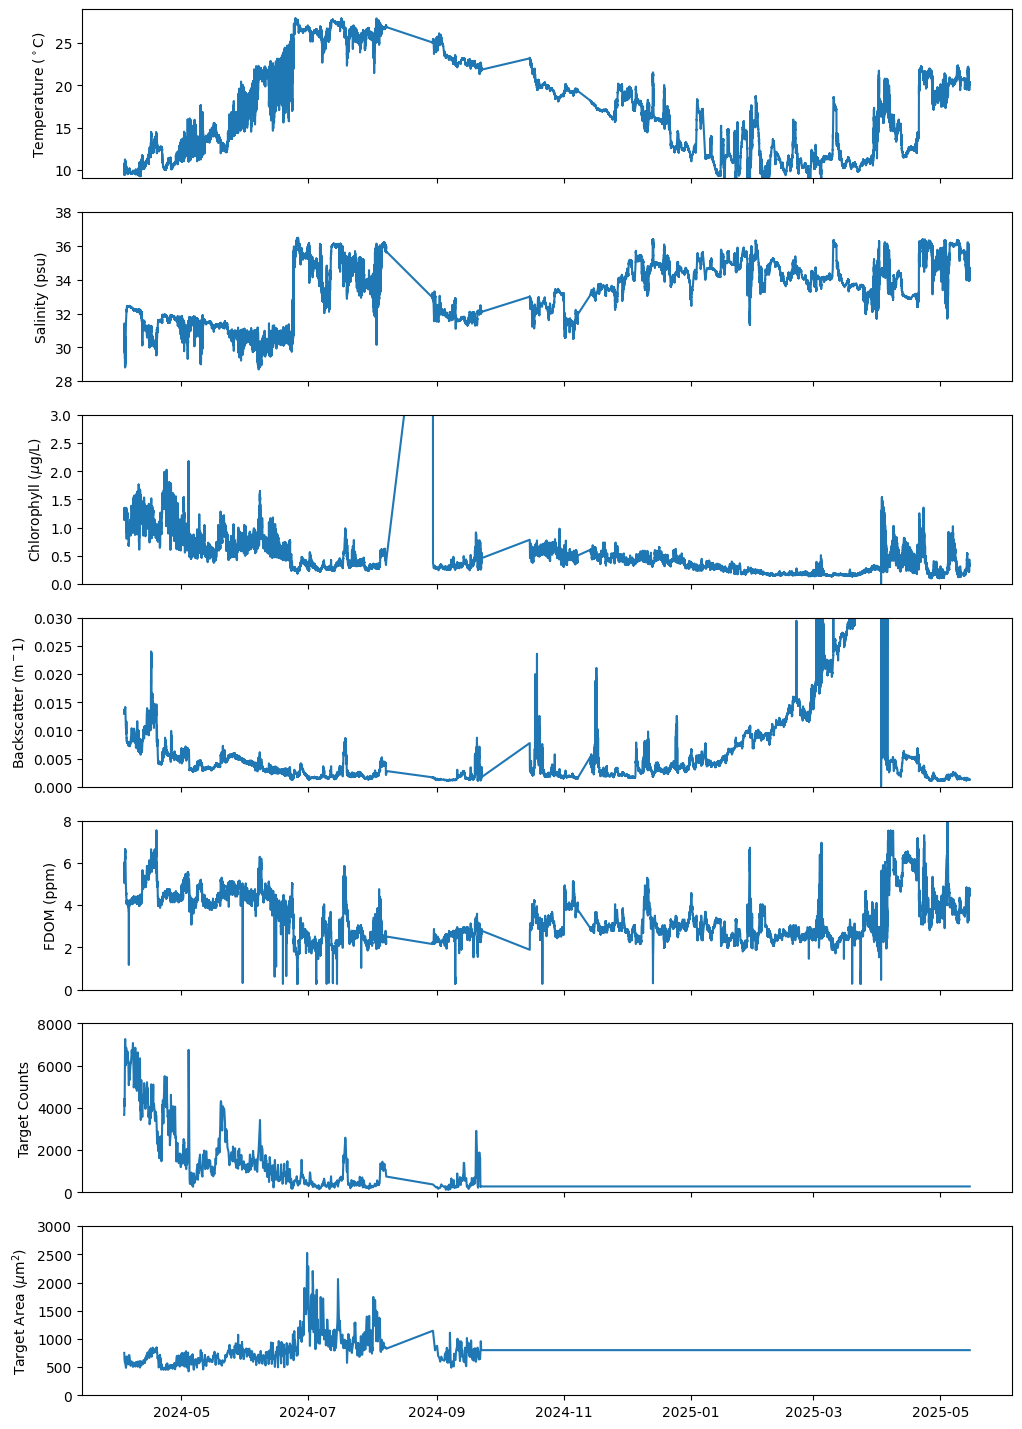

In [15]:
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(12, 18))

ax1 = plt.subplot(7, 1, 1)
plt.plot(merge.time, merge.sea_water_temperature)
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([9, 29])
plt.ylabel('Temperature ($^\circ$C)')

ax2 = plt.subplot(7, 1, 2, sharex=ax1)
plt.plot(merge.time, merge.sea_water_practical_salinity)
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([28, 38])
plt.ylabel('Salinity (psu)')

ax3 = plt.subplot(7, 1, 3, sharex=ax1)
plt.plot(merge.time, merge.estimated_chlorophyll)
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 3])
plt.ylabel('Chlorophyll ($\mu$g/L)')

ax4 = plt.subplot(7, 1, 4, sharex=ax1)
plt.plot(merge.time, merge.optical_backscatter)
plt.setp(ax4.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 0.03])
plt.ylabel('Backscatter (m$^-1$)')

ax5 = plt.subplot(7, 1, 5, sharex=ax1)
plt.plot(merge.time, merge.fluorometric_cdom)
plt.setp(ax5.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 8])
plt.ylabel('FDOM (ppm)')

ax6 = plt.subplot(7, 1, 6, sharex=ax1)
plt.plot(merge.time, merge.target_counts)
plt.setp(ax6.get_xticklabels(), visible=False) # turn off x-axis ticklabels
plt.ylim([0, 8000])
plt.ylabel('Target Counts')

ax6 = plt.subplot(7, 1, 7, sharex=ax1)
plt.plot(merge.time, merge.target_area)
plt.ylim([0, 3000])
plt.ylabel('Target Area ($\mu$m$^2$)')

plt.show()

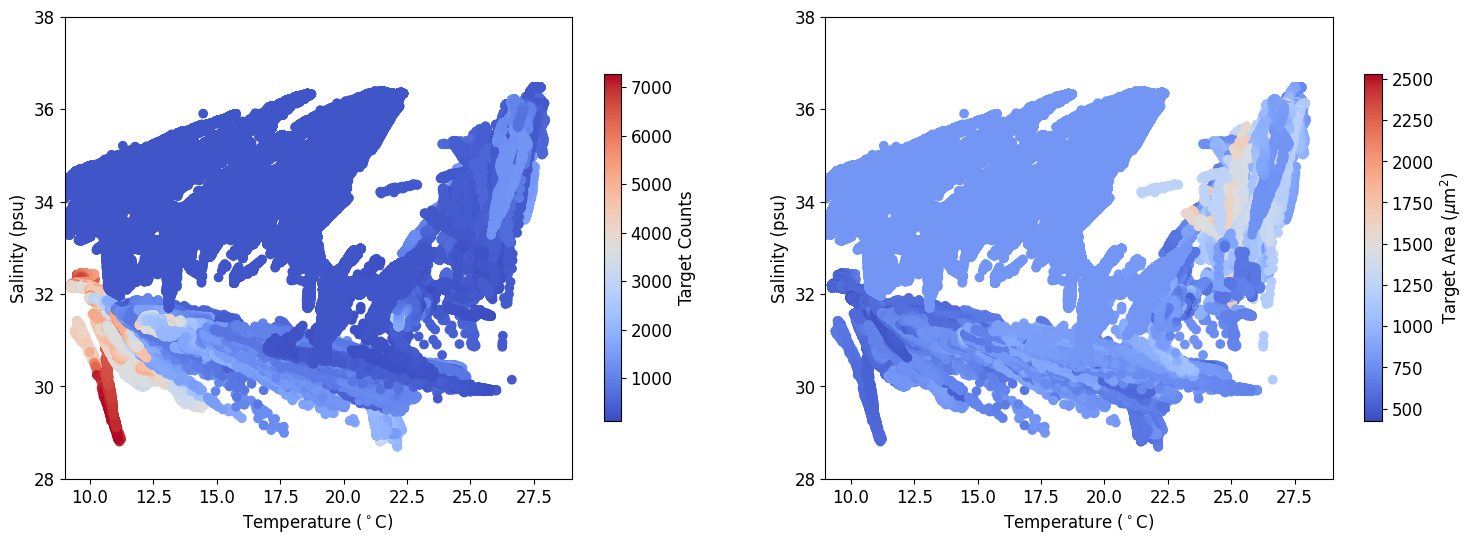

In [16]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 2, 1)
plt.scatter(merge['sea_water_temperature'], merge['sea_water_practical_salinity'], c=merge['target_counts'], cmap='coolwarm')
cbar = plt.colorbar(shrink=0.75, label='Target Counts')
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Salinity (psu)')
plt.xlim([9, 29])
plt.ylim([28, 38])

plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.scatter(merge['sea_water_temperature'], merge['sea_water_practical_salinity'], c=merge['target_area'], cmap='coolwarm')
cbar = plt.colorbar(shrink=0.75, label='Target Area ($\mu$m$^2$)')
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Salinity (psu)')

plt.show()